# Unsupervised clustering of genome profiles

The metadata labels are wrong. Can we identify clusters using unsupervised techniques?

+ PCA
+ tSNE
+ UMAP
+ diffusion map

In [1]:
setwd("..")

In [52]:
library(readr)
library(dplyr)
library(purrr)
library(tidyr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(Rtsne)
library(umap)
source("scripts/utils.R")

In [4]:
set.seed(1) 

In [55]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Read in gather results and sample metadata

In [6]:
# separate empty files from populated files
files <- Sys.glob("results/*gather.csv")
empty_files <- character()
populated_files <- character()
for(i in 1:length(files)){
    # check and see if the file is empty, e.g. has not gather matches
    file_size <- file.size(files[i])
    if(file_size == 0){
        empty_files = c(empty_files, files[i])
    } else {
        populated_files = c(populated_files, files[i])
    }
}

In [7]:
# read in populated files
# empty files are ignored
gather_results <- populated_files %>%
  map_dfr(read_gather)

In [8]:
# join gather results with metadata
runinfo <- read_csv("all.runinfo.csv", show_col_types = F)
gather_results <- left_join(gather_results, runinfo, by = c("query_name" = "Run"))

Warning message:
“One or more parsing issues, see `problems()` for details”


## Format for clustering

In [9]:
# samples (metagenomes) need to be rownames, names (genomes) need to be columns, class (ScientificName) can be a column at end of df for now
gather_formatted <- gather_results %>%
  mutate(accession = gsub(" .*", "", name)) %>% # make genome names more friendly
  select(query_name, ScientificName, accession, f_unique_to_query) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("query_name", "ScientificName"), names_from = accession, values_from = f_unique_to_query)

In [13]:
gather_formatted <- gather_formatted %>% 
  select(-ScientificName) %>%
  replace(is.na(.), 0)
# gather_formatted[is.na(gather_formatted)] <- 0 # replace NAs with 0s

In [14]:
gather_formatted[1:5, 1:5]
dim(gather_formatted)

query_name,GCF_003478165.1,GCF_012271835.1,GCF_003459645.1,GCF_001404335.1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DRR014176,0.03421053,0.02157895,0.02052632,0.02052632
DRR019507,0.00000000,0.00000000,0.00000000,0.00000000
DRR021939,0.00000000,0.00000000,0.00000000,0.00000000
DRR025071,0.00000000,0.00000000,0.00000000,0.00000000
DRR033608,0.00000000,0.00000000,0.00000000,0.00000000


[1]  7999 77543

## PCA

In [15]:
gather_pca <- gather_formatted %>%
  column_to_rownames("query_name") %>%
  prcomp()

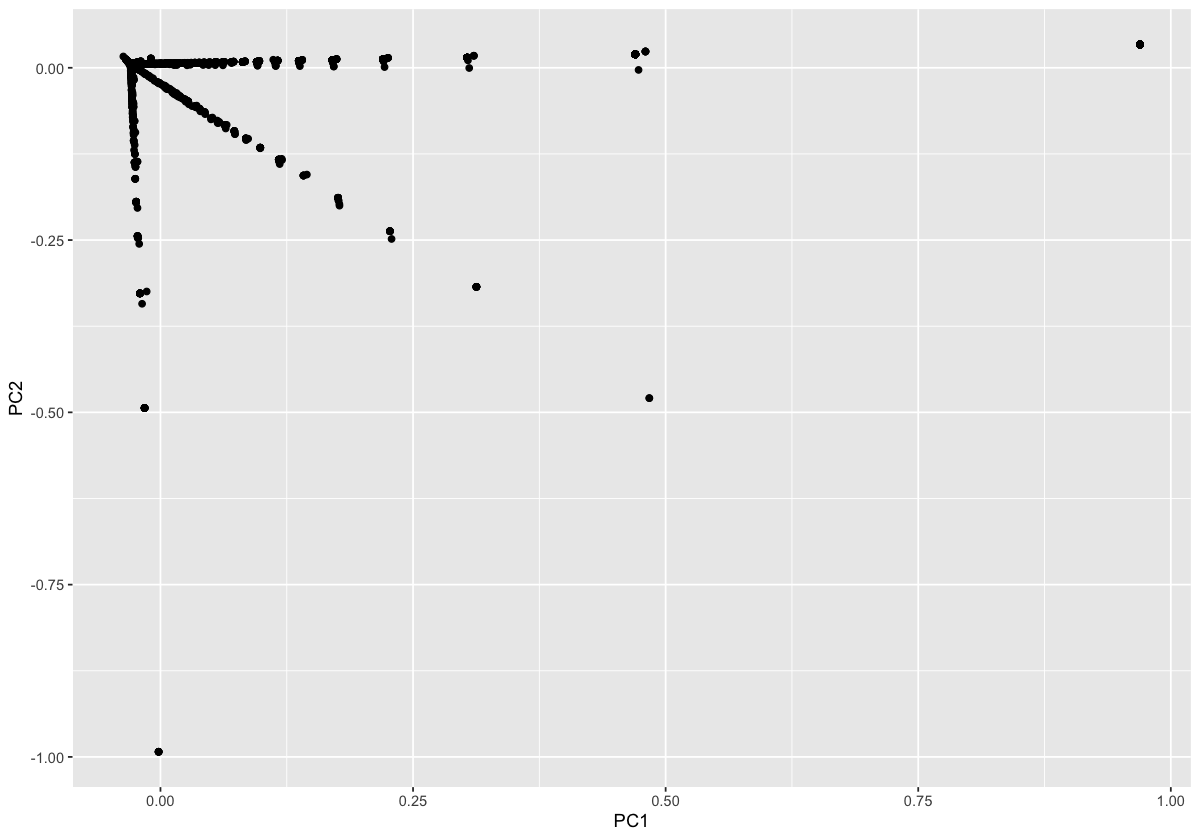

In [16]:
ggplot(as.data.frame(gather_pca$x), aes(x = PC1, y = PC2)) +
  geom_point()

## tSNE

https://datavizpyr.com/how-to-make-tsne-plot-in-r/

In [21]:
gather_tsne <- gather_formatted %>%
  column_to_rownames("query_name") %>%
  scale() %>% 
  Rtsne()

ERROR: Error: vector memory exhausted (limit reached?)


## UMAP

In [25]:
gather_umap <- gather_formatted %>%
  column_to_rownames("query_name") %>%
  scale() %>% 
  umap()

In [31]:
# read in metadata
runinfo <- read_csv("all.runinfo.csv", show_col_types = F)
ebi <- read_csv("ebi_mgnify_samples.csv", show_col_types = F)

Warning message:
“One or more parsing issues, see `problems()` for details”


In [48]:
gather_umap_results <- as.data.frame(gather_umap$layout) %>%
  rownames_to_column("Run") %>%
  left_join(runinfo, by = "Run") %>%
  left_join(ebi, by = c("Sample" = "accession"))

In [49]:
biome_fill <- gather_umap_results %>%
  group_by(biome) %>% 
  tally() %>%
  arrange(desc(n)) %>%
  select(biome, num_biome = n)



In [50]:
gather_umap_results <- left_join(gather_umap_results, biome_fill, by = "biome") %>%
  mutate(biome_fill = ifelse(num_biome > 10, biome, "other"))

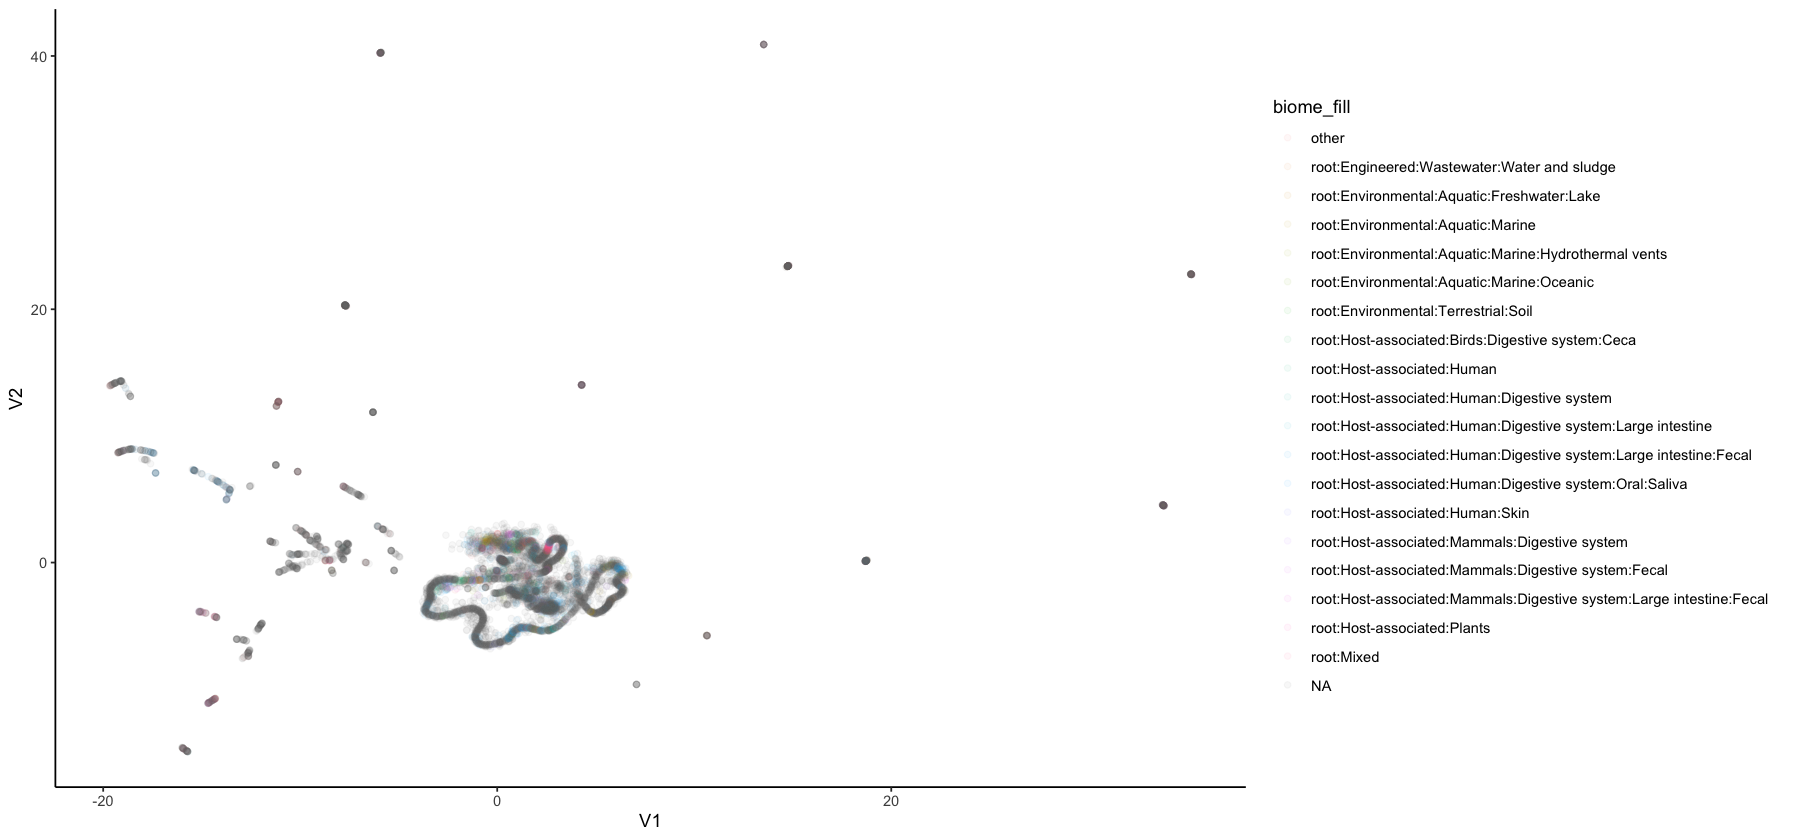

In [56]:
ggplot(gather_umap_results, aes(x = V1, y = V2, color = biome_fill)) +
  geom_point(alpha = .05) +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

## Diffusion map

In [57]:
## as implemented here: https://doi.org/10.6084/m9.figshare.12864011.v4
## standardize columns func
norm_mat <- function(mat){
  ms <- apply(mat, 2, function(col) (col - mean(col)) / sd(col))
  ms
}
## compute euclid dist and standrdize to similarities
get_euc <- function(mat, n.threads = 1, alt = 'euclidean'){
  if(n.threads > 1){
    eu <- parDist(mat, method = alt, threads = n.threads) %>% as.matrix()
    ieu <- 1 / eu
    diag(ieu) <- 0
  }
  
  if(n.threads == 1){
    eu <- dist(mat, method = alt) %>% as.matrix()
    ieu <- 1 / eu
    diag(ieu) <- 0
  }
  ieu
}
## function to threshold the normalized distance mat
threshold <- function(mat, top_k = 10){
  thr <- mat
  tnr <- nrow(thr)
  ## set similarities outside of the top k to 0
  for(i in 1:tnr){
    ## rank entries in each row in reverse order (so largest value == rank 1), 
    ## and set entries that are outside of 1:k to 0
    thr[i, !rank(-thr[i, ], ties.method = 'random') %in% 1:top_k] <- 0
  }
  
  for(i in 1:tnr){
    for(j in 1:tnr){
      if(thr[i, j] == 0 & thr[j, i] != 0){
        thr[i, j] <- thr[j, i]
      }
    }
  }
  thr
}
## function to calculate norm laplacian
get_laplac <- function(mat){
  L <- -mat
  S <- rowSums(mat)
  nL <- L / S
  diag(nL) <- 1
  nL
}

In [58]:
## build diffusion map
nm <- gather_formatted %>%
  column_to_rownames("query_name") %>% 
  norm_mat()                    # normalize

aff <- nm %>%
  get_euc(., n.threads = 1) %>% 
  threshold(., top_k = 10)      # make affinity matrix

Lij <- aff %>% get_laplac()     # compute laplacian

eig <- eigen(Lij)               # smallest keig vectors

evl <- eig$values %>%           # get eigenvalues
  Re() %>%
  round(., digits = 10)

evc <- eig$vectors %>%          # get eigenvectors
  Re() %>%
  round(., digits = 10)

ERROR: Error: vector memory exhausted (limit reached?)


In [ ]:
# create objects containing diffusion components
for(d in 1:length(evl)){
  assign(paste('dim', d, sep = '_'),
         Re(evc[, rank(evl) == (d + 1)])
  )
}

In [ ]:
k_eig <- 10                     # specify num of variables you want to keep
dat <- do.call(mapply, c(FUN = cbind, mget(paste0("dim_", 1:(k_eig))))) %>%
  t() %>%
  as.data.frame()               # merge in array
colnames(dat) <- paste(paste('DC', 1:(k_eig), sep = ''))
rownames(dat) <- rownames(Lij)  # add labels
gather_dm <- dat %>%            # replace accession as column in df
  rownames_to_column("run") 